In [1]:
START_DATE = "02/29/2020"
END_DATE = "05/30/2020"
TRAIN_SPLIT_IDX = 60
TIME_WINDOW_SIZE = 7
DS_LABEL = "test_gen"

In [2]:
import random
import torch
import math
import pandas as pd
import pathlib


def getDateRange(start, end):
    start_date  = pd.to_datetime(start)
    end_date    = pd.to_datetime(end)
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    return dates

In [3]:
# by borough

death_df = pd.read_csv("https://raw.githubusercontent.com/nychealth/coronavirus-data/master/trends/deaths-by-day.csv")
case_df = pd.read_csv("https://raw.githubusercontent.com/nychealth/coronavirus-data/master/trends/cases-by-day.csv")

death_df['date_of_interest'] = pd.to_datetime(death_df['date_of_interest'])
case_df['date_of_interest'] = pd.to_datetime(case_df['date_of_interest'])

In [4]:
BOROUGH_FIPS_MAP = {
    'BX' : 36005,
    'BK' : 36047,
    'MN' : 36061,
    'QN' : 36081,
    'SI' : 36085,
}

FIPS_BOROUGH_MAP = {
    36005 : 'BX',
    36047 : 'BK',
    36061 : 'MN',
    36081 : 'QN',
    36085 : 'SI',
}

In [5]:
subset_cols = ['date_of_interest', 'BX_DEATH_COUNT', 'BX_DEATH_COUNT_7DAY_AVG',
       'BK_DEATH_COUNT', 'BK_DEATH_COUNT_7DAY_AVG', 'MN_DEATH_COUNT',
       'MN_DEATH_COUNT_7DAY_AVG', 'QN_DEATH_COUNT', 'QN_DEATH_COUNT_7DAY_AVG',
       'SI_DEATH_COUNT', 'SI_DEATH_COUNT_7DAY_AVG']
death_subset_df = death_df.loc[(START_DATE <= death_df['date_of_interest']) & (death_df['date_of_interest'] <= END_DATE), subset_cols]
death_subset_df = pd.melt(death_subset_df, id_vars=['date_of_interest'])
death_subset_df[['borough', 'metric']] = death_subset_df['variable'].str.split('_', n=1, expand=True)
death_subset_df = death_subset_df.pivot(index=['date_of_interest','borough'], columns='metric', values='value').reset_index()

death_subset_df['FIPS'] = death_subset_df['borough'].map(BOROUGH_FIPS_MAP)

death_subset_df['node_key'] = death_subset_df['FIPS'].astype(str) + "-" + death_subset_df['date_of_interest'].astype('str') 
long_cols = ['date_of_interest', 'FIPS', 'node_key', 'DEATH_COUNT', 'DEATH_COUNT_7DAY_AVG']
death_subset_df = death_subset_df[long_cols]
death_subset_df.head()

metric,date_of_interest,FIPS,node_key,DEATH_COUNT,DEATH_COUNT_7DAY_AVG
0,2020-02-29,36047,36047-2020-02-29,0,0
1,2020-02-29,36005,36005-2020-02-29,0,0
2,2020-02-29,36061,36061-2020-02-29,0,0
3,2020-02-29,36081,36081-2020-02-29,0,0
4,2020-02-29,36085,36085-2020-02-29,0,0


In [6]:
# compute deltas
death_subset_df = death_subset_df.sort_values(by=['date_of_interest', 'FIPS'])

# death_subset_df['DEATH_DELTA'] = death_subset_df.groupby(['FIPS'])['DEATH_COUNT'].diff(-1).fillna(0)
death_subset_df['DEATH_DELTA'] = death_subset_df.groupby(['FIPS'])['DEATH_COUNT_7DAY_AVG'].diff(-1).fillna(0)

death_subset_df['DEATH_DELTA'] = death_subset_df['DEATH_DELTA'] * -1


In [7]:
subset_cols = ['date_of_interest',
               'BX_CASE_COUNT', 'BX_CASE_COUNT_7DAY_AVG',
               'BK_CASE_COUNT', 'BK_CASE_COUNT_7DAY_AVG',
               'MN_CASE_COUNT', 'MN_CASE_COUNT_7DAY_AVG',
               'QN_CASE_COUNT', 'QN_CASE_COUNT_7DAY_AVG',
               'SI_CASE_COUNT', 'SI_CASE_COUNT_7DAY_AVG']
case_subset_df = case_df.loc[(START_DATE <= case_df['date_of_interest']) & (case_df['date_of_interest'] <= END_DATE), subset_cols]
case_subset_df = pd.melt(case_subset_df, id_vars=['date_of_interest'])
case_subset_df[['borough', 'metric']] = case_subset_df['variable'].str.split('_', n=1, expand=True)
case_subset_df = case_subset_df.pivot(index=['date_of_interest','borough'], columns='metric', values='value').reset_index()

case_subset_df['FIPS'] = case_subset_df['borough'].map(BOROUGH_FIPS_MAP)
case_subset_df['node_key'] = case_subset_df['FIPS'].astype(str) + "-" + case_subset_df['date_of_interest'].astype('str')
long_cols = ['date_of_interest', 'FIPS', 'node_key', 'CASE_COUNT', 'CASE_COUNT_7DAY_AVG']

case_subset_df = case_subset_df[long_cols]
case_subset_df.head()

metric,date_of_interest,FIPS,node_key,CASE_COUNT,CASE_COUNT_7DAY_AVG
0,2020-02-29,36047,36047-2020-02-29,0,0
1,2020-02-29,36005,36005-2020-02-29,0,0
2,2020-02-29,36061,36061-2020-02-29,1,0
3,2020-02-29,36081,36081-2020-02-29,0,0
4,2020-02-29,36085,36085-2020-02-29,0,0


In [8]:
# compute deltas
case_subset_df = case_subset_df.sort_values(by=['date_of_interest', 'FIPS'])

# case_subset_df['CASE_DELTA'] = case_subset_df.groupby(['FIPS'])['CASE_COUNT'].diff(-1).fillna(0)
case_subset_df['CASE_DELTA'] = case_subset_df.groupby(['FIPS'])['CASE_COUNT_7DAY_AVG'].diff(-1).fillna(0)

case_subset_df['CASE_DELTA'] = case_subset_df['CASE_DELTA'] * -1
case_subset_df

metric,date_of_interest,FIPS,node_key,CASE_COUNT,CASE_COUNT_7DAY_AVG,CASE_DELTA
1,2020-02-29,36005,36005-2020-02-29,0,0,-0.0
0,2020-02-29,36047,36047-2020-02-29,0,0,-0.0
2,2020-02-29,36061,36061-2020-02-29,1,0,-0.0
3,2020-02-29,36081,36081-2020-02-29,0,0,-0.0
4,2020-02-29,36085,36085-2020-02-29,0,0,-0.0
...,...,...,...,...,...,...
456,2020-05-30,36005,36005-2020-05-30,82,148,-0.0
455,2020-05-30,36047,36047-2020-05-30,101,194,-0.0
457,2020-05-30,36061,36061-2020-05-30,38,83,-0.0
458,2020-05-30,36081,36081-2020-05-30,110,168,-0.0


In [9]:
dates = getDateRange(START_DATE, END_DATE)
fips_list = list(BOROUGH_FIPS_MAP.values())

node_dict = dict()

curr_idx = 0
for d in dates:
    for f in fips_list:
        key_str = f"{f}-{d.strftime('%Y-%m-%d')}"
        node_dict[key_str] = curr_idx
        curr_idx += 1

pd.DataFrame.from_dict(node_dict, orient='index')

,0
36005-2020-02-29,0
36047-2020-02-29,1
36061-2020-02-29,2
36081-2020-02-29,3
36085-2020-02-29,4
...,...
36005-2020-05-30,455
36047-2020-05-30,456
36061-2020-05-30,457
36081-2020-05-30,458


In [10]:
deltaT = pd.Timedelta(value=1, unit="D") 

for f in list(BOROUGH_FIPS_MAP.values()):
    for d in dates:
        for dd in range(TIME_WINDOW_SIZE-1):
            prev = pd.to_datetime(d) - deltaT * (dd + 1)
            
            selection_current = (case_subset_df['FIPS'] == f) & (case_subset_df['date_of_interest'] == d)
            selection_prev = (case_subset_df['FIPS'] == f) & (case_subset_df['date_of_interest'] == prev)
            if prev < pd.to_datetime(START_DATE):
                prev_cases = 0
            else:
                prev_cases = case_subset_df.loc[selection_prev, 'CASE_COUNT'].values[0]
            case_subset_df.loc[selection_current, f'CASE_COUNT_PREV_{dd}'] = prev_cases

            selection_current = (death_subset_df['FIPS'] == f) & (death_subset_df['date_of_interest'] == d)
            selection_prev = (death_subset_df['FIPS'] == f) & (death_subset_df['date_of_interest'] == prev)
            if prev < pd.to_datetime(START_DATE):
                prev_deaths = 0
            else:
                prev_deaths = case_subset_df.loc[selection_prev, 'CASE_COUNT'].values[0]
            death_subset_df.loc[selection_current, f'DEATH_COUNT_PREV_{dd}'] = prev_deaths


## Mobility Data

In [11]:
DTYPE = {
    'census_fips_code':'Int64',
    'date':'str',
}
mobility_report_df = pd.read_csv("../data/raw/2020_US_Region_Mobility_Report.csv", dtype=DTYPE)
mobility_report_df['date'] = pd.to_datetime(mobility_report_df['date'])

In [12]:
counties = ['Bronx County', 'Kings County', 'New York County', 'Queens County', 'Richmond County']
subset_cols = [
    "census_fips_code",
    "date",
    "retail_and_recreation_percent_change_from_baseline",
    "grocery_and_pharmacy_percent_change_from_baseline",
    "parks_percent_change_from_baseline",
    "transit_stations_percent_change_from_baseline",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline"]

nyc_mobility_report_df = mobility_report_df.loc[(mobility_report_df.sub_region_1 == "New York") & (mobility_report_df.sub_region_2.isin(counties)) & (START_DATE <= mobility_report_df['date'])& (mobility_report_df['date'] <= END_DATE), subset_cols]


In [13]:
nyc_mobility_report_df.rename(columns={"census_fips_code": "FIPS"}, inplace=True)

In [14]:
nyc_mobility_report_df.head()

,FIPS,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
466922,36005,2020-02-29,10.0,-1.0,-15.0,8.0,4.0,-1.0
466923,36005,2020-03-01,9.0,2.0,-6.0,3.0,0.0,0.0
466924,36005,2020-03-02,13.0,6.0,-7.0,8.0,6.0,-1.0
466925,36005,2020-03-03,8.0,7.0,6.0,4.0,4.0,0.0
466926,36005,2020-03-04,11.0,7.0,16.0,2.0,2.0,-1.0


## build features

In [97]:
x_t = case_subset_df.merge(death_subset_df, on=['date_of_interest','FIPS', 'node_key'])
x_t = x_t.merge(nyc_mobility_report_df, left_on=['date_of_interest','FIPS'], right_on=['date','FIPS'])
print(x_t.head())
x_t_cols = ['CASE_COUNT',
       'CASE_COUNT_7DAY_AVG', 'CASE_COUNT_PREV_0',
       'CASE_COUNT_PREV_1', 'CASE_COUNT_PREV_2', 'CASE_COUNT_PREV_3',
       'CASE_COUNT_PREV_4', 'CASE_COUNT_PREV_5',
       'DEATH_COUNT', 'DEATH_COUNT_7DAY_AVG',
       'DEATH_COUNT_PREV_0', 'DEATH_COUNT_PREV_1', 'DEATH_COUNT_PREV_2',
       'DEATH_COUNT_PREV_3', 'DEATH_COUNT_PREV_4', 'DEATH_COUNT_PREV_5','retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']
x_t = torch.tensor(x_t[x_t_cols].values, dtype=torch.float32)
# y_t = torch.tensor(case_subset_df['CASE_DELTA'].values, dtype=torch.float32)
y_t = torch.tensor(case_subset_df['CASE_DELTA'].values + case_subset_df['CASE_COUNT_7DAY_AVG'].values, dtype=torch.float32)

  date_of_interest   FIPS          node_key  CASE_COUNT  CASE_COUNT_7DAY_AVG  \
0       2020-02-29  36005  36005-2020-02-29           0                    0   
1       2020-02-29  36047  36047-2020-02-29           0                    0   
2       2020-02-29  36061  36061-2020-02-29           1                    0   
3       2020-02-29  36081  36081-2020-02-29           0                    0   
4       2020-02-29  36085  36085-2020-02-29           0                    0   

   CASE_DELTA  CASE_COUNT_PREV_0  CASE_COUNT_PREV_1  CASE_COUNT_PREV_2  \
0        -0.0                0.0                0.0                0.0   
1        -0.0                0.0                0.0                0.0   
2        -0.0                0.0                0.0                0.0   
3        -0.0                0.0                0.0                0.0   
4        -0.0                0.0                0.0                0.0   

   CASE_COUNT_PREV_3  ...  DEATH_COUNT_PREV_3  DEATH_COUNT_PREV_4  \
0    

(array([18322., 18336., 18353., 18367., 18383., 18397., 18414.]),
 [Text(18322.0, 0, '2020-03-01'),
  Text(18336.0, 0, '2020-03-15'),
  Text(18353.0, 0, '2020-04-01'),
  Text(18367.0, 0, '2020-04-15'),
  Text(18383.0, 0, '2020-05-01'),
  Text(18397.0, 0, '2020-05-15'),
  Text(18414.0, 0, '2020-06-01')])

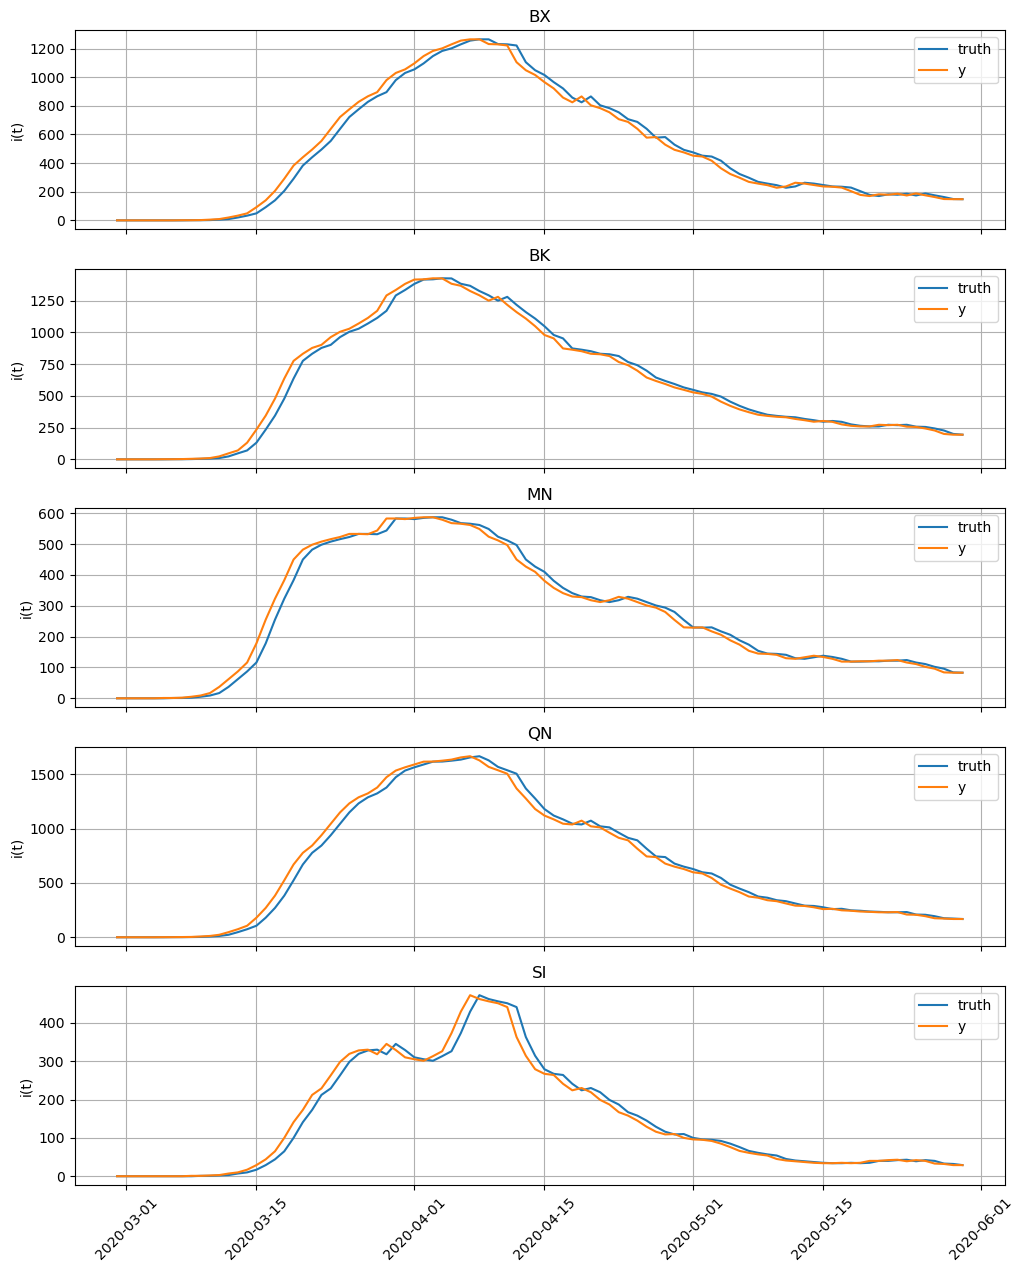

In [122]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, figsize=(12,15), sharex=True)

for i, f in enumerate(fips_list):
    ax[i].plot(case_subset_df.loc[case_subset_df['FIPS'] == f, 'date_of_interest'], case_subset_df.loc[case_subset_df['FIPS'] == f, 'CASE_COUNT_7DAY_AVG'].values, '-', label='truth')
    ax[i].plot(case_subset_df.loc[case_subset_df['FIPS'] == f, 'date_of_interest'],
               case_subset_df.loc[case_subset_df['FIPS'] == f, 'CASE_COUNT_7DAY_AVG'].values + case_subset_df.loc[case_subset_df['FIPS'] == f, 'CASE_DELTA'].values,
               '-', label='y')
    ax[i].legend()
    ax[i].set_title(FIPS_BOROUGH_MAP[f])
    ax[i].set_ylabel(r'i(t)')

    ax[i].grid()

plt.xticks(rotation=45)

## Adjency list

In [99]:
fips_list = list(BOROUGH_FIPS_MAP.values())

In [100]:
coo_list   = []

# create spatial edges (all boroughs are connected to each other)
for d in dates:
    for u in fips_list:
        for v in fips_list:
            u_key = f"{u}-{d.strftime('%Y-%m-%d')}"
            v_key = f"{v}-{d.strftime('%Y-%m-%d')}"
            u_idx = node_dict[u_key]
            v_idx = node_dict[v_key]
            coo_list.append([u_idx, v_idx])
print(len(coo_list), 'spatial edges')

# create temporal edges
temp_count = 0
for base_day_idx in range(0, len(dates)-TIME_WINDOW_SIZE):
    base_day = dates[base_day_idx]
    base_str = base_day.strftime('%Y-%m-%d')
    for future_day in dates[base_day_idx+1 : base_day_idx+TIME_WINDOW_SIZE+1]:
        future_str = future_day.strftime('%Y-%m-%d')

        # iterate over each county fips
        for f in fips_list:

            # Need a link from base_day to future_day
            u_key = f"{f}-{base_str}"
            v_key = f"{f}-{future_str}"
            
            u_idx = node_dict[u_key]
            v_idx = node_dict[v_key]
            # Only add past->future link. 
            coo_list.append([u_idx, v_idx])
            temp_count += 1
                
print(temp_count, 'temporal edges')

# print("{} adj links, {} temp links in cool list".format(adj_count, temp_count))
# print("{} key errors while generating coo list".format(key_errors))
# return coo_list

2300 spatial edges
2975 temporal edges


In [101]:

coo_df = pd.DataFrame(coo_list)
# coo_df.to_csv('../data/processed/static_coo_list.csv')
# save_df.to_csv(filepath, header=False, index=False)


In [102]:
coo_t   = torch.tensor(coo_df.values, dtype=torch.int64)
coo_t   = coo_t.reshape((2, len(coo_df.values)))
coo_t

tensor([[  0,   0,   0,  ...,  46,  71,  47],
        [ 72,  48,  73,  ..., 458, 424, 459]])

# Edge weights

In [131]:
import glob
import os

mobility_files = glob.glob("../data/raw/mobility/*.csv")
mobility_dates = [os.path.basename(f).split("_")[0] for f in mobility_files]
mobility_dates = pd.to_datetime(mobility_dates)
mobility_dates = mobility_dates.sort_values()

day_mobility_dict = dict()

for d in dates:
    next_sunday = d + pd.offsets.Week(n=0, weekday=0)
    day_key = d.strftime('%Y-%m-%d')
    day_mobility_dict[day_key] = next_sunday.strftime('%Y-%m-%d') + "_mobility.csv"

In [129]:
path = "../data/raw/mobility/"

pd.read_csv(path + "2020-03-02_mobility.csv")

,destination,origin,visitor_home_aggregation,end
0,Bronx,Bronx,34210,2020-03-02
1,Bronx,Brooklyn,2606,2020-03-02
2,Bronx,Manhattan,3264,2020-03-02
3,Bronx,Queens,2120,2020-03-02
4,Bronx,Staten Island,293,2020-03-02
5,Brooklyn,Bronx,1177,2020-03-02
6,Brooklyn,Brooklyn,38720,2020-03-02
7,Brooklyn,Manhattan,1537,2020-03-02
8,Brooklyn,Queens,4989,2020-03-02
9,Brooklyn,Staten Island,1721,2020-03-02


In [132]:
for row in coo_df.iterrows()

SyntaxError: expected ':' (4174276866.py, line 1)

# train / test mask

In [105]:
train_mask = [0 for i in range(len(node_dict))]
test_mask  = [0 for i in range(len(node_dict))]

for i in range(len(dates)):
    for fips in fips_list:
        date_str = dates[i].strftime('%Y-%m-%d')
        key_str = "{}-{}".format(fips, date_str)

        idx = node_dict[key_str]
        if i < TRAIN_SPLIT_IDX:
            # Training!
            train_mask[idx] = 1
        else:
            # Testing!
            test_mask[idx] = 1

In [106]:
import torch_geometric
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = torch_geometric.data.Data(
    x=x_t.to(device),
    y=y_t.to(device),
    edge_index=coo_t.to(device),
)

data.train_mask = torch.tensor(np.array(train_mask), dtype=torch.bool).to(device)
data.test_mask = torch.tensor(np.array(test_mask), dtype=torch.bool).to(device)

# model

In [107]:
class RMSLELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [108]:
import torch
import torch_geometric.utils as U
import torch.nn.parameter as P
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv


NODE_FEATURES = 22
OUT_DIM = 1
DROPOUT = 0.1

### Baseline Temporal Skip Model
class MLP(torch.nn.Module):
	def __init__(self, num_hidden, dim_in, dim_out):
		super(MLP, self).__init__()
		self.H = num_hidden
		self.linear_1 = Linear(dim_in, self.H)
		self.linear_2 = Linear(self.H, dim_out)

	def forward(self, x):
		h = self.linear_1(x)
		h = self.linear_2(h)
		return h


class TemporalSkip(torch.nn.Module):
	def __init__(self):
		super(TemporalSkip, self).__init__()

		# I ?think? these are values similar to what the paper uses.
		self.MLP_embed = MLP(64, NODE_FEATURES, 32)
		self.GCN1      = GCNConv(32, 32)
		self.GCN2      = GCNConv(64, 32)
		self.GCN3      = GCNConv(64, 32)
		self.MLP_pred  = MLP(32, 64, OUT_DIM)
		
	def forward(self, x, edge_index):
		# Initial Embedding
		h = self.MLP_embed(x)
		h = F.dropout(h, p=DROPOUT, training=self.training)
		h0 = h

		# First Hop
		h = self.GCN1(h, edge_index)
		h = F.dropout(h, p=DROPOUT, training=self.training)
		h = h.relu()
		h = torch.cat((h, h0), dim=1)

		# Second Hop
		h = self.GCN2(h, edge_index)
		h = F.dropout(h, p=DROPOUT, training=self.training)
		h = h.relu()
		h = torch.cat((h, h0), dim=1)

		# Prediction layer
		out = self.MLP_pred(h)
		return out

In [109]:
from tqdm.auto import tqdm

graph = data.to(device)
print(graph)

model     = TemporalSkip().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()
# criterion = RMSLELoss()

def train():
	model.train()
	optimizer.zero_grad()
	out = model(graph.x.to(device), graph.edge_index.to(device))
	loss = criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask])
	loss.backward()
	optimizer.step()
	return loss

def test():
	model.eval()
	out  = model(graph.x, graph.edge_index)
	loss = criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask])

	return loss

loss_list = []
for epoch in tqdm(range(1000)):
	loss = train()
	loss_list.append(loss.cpu().detach().numpy())
	# print("epoch {:0>} - {}".format(epoch, loss))


test_acc = test()
print("final test loss: {}".format(test_acc))

Data(x=[460, 22], edge_index=[2, 5275], y=[460], train_mask=[460], test_mask=[460])


  0%|          | 0/10000 [00:00<?, ?it/s]

final test loss: 542.8773193359375


In [110]:
model.eval()
out  = model(graph.x, graph.edge_index)
criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask])

tensor(368.5879, device='cuda:0', grad_fn=<MseLossBackward0>)

In [111]:
criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask])

tensor(542.8773, device='cuda:0', grad_fn=<MseLossBackward0>)

In [112]:
y_test = graph.y[graph.test_mask].cpu().numpy()
out_test = out[graph.test_mask].detach().cpu().numpy()

y_train = graph.y[graph.train_mask].cpu().numpy()
out_train = out[graph.train_mask].detach().cpu().numpy()


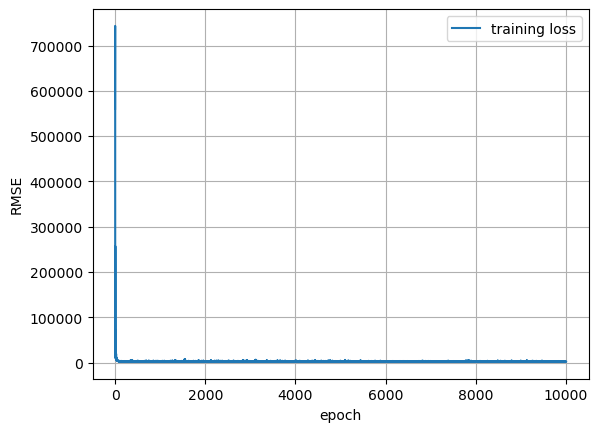

In [113]:
fig, ax = plt.subplots()

ax.plot(loss_list, label='training loss')
ax.set_xlabel('epoch')
ax.set_ylabel('RMSE')
ax.grid()
ax.legend()

Text(0.5, 1.0, 'Training set')

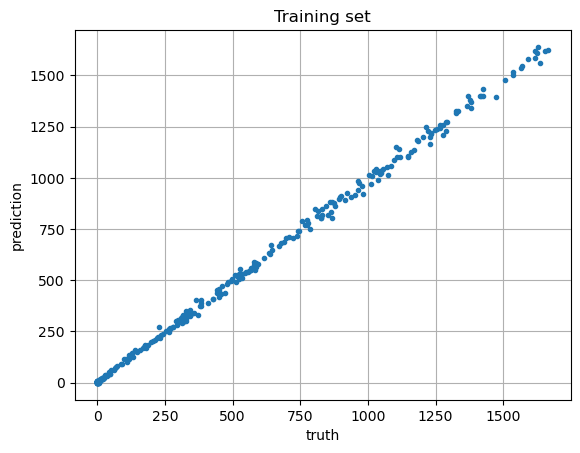

In [114]:

fig, ax = plt.subplots()
ax.plot(y_train, out_train, '.')
ax.grid()
ax.set_xlabel('truth')
ax.set_ylabel('prediction')
ax.set_title('Training set')

Text(0.5, 1.0, 'Test set')

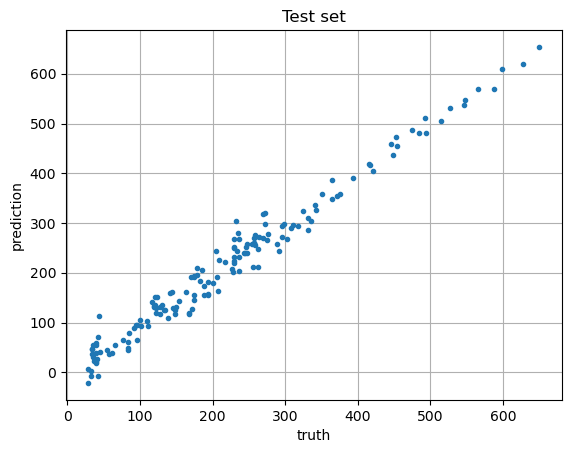

In [115]:
fig, ax = plt.subplots()
ax.plot(y_test, out_test, '.')
ax.grid()
ax.set_xlabel('truth')
ax.set_ylabel('prediction')
ax.set_title('Test set')

In [116]:
pred_df = pd.DataFrame()
pred_df['key'] = np.array(list(node_dict.keys()))[np.where(np.array(test_mask)==1)]
pred_df['truth'] = y_test
pred_df['pred'] = out_test

pred_df[['fips','date']] = pred_df['key'].str.split('-',n=1, expand=True)
pred_df['date'] = pd.to_datetime(pred_df['date'])

In [117]:
train_df = pd.DataFrame()
train_df['key'] = np.array(list(node_dict.keys()))[np.where(np.array(train_mask)==1)]
train_df['truth'] = y_train
train_df['pred'] = out_train

train_df[['fips','date']] = train_df['key'].str.split('-',n=1, expand=True)
train_df['date'] = pd.to_datetime(train_df['date'])

(array([18322., 18336., 18353., 18367., 18383., 18397., 18414.]),
 [Text(18322.0, 0, '2020-03-01'),
  Text(18336.0, 0, '2020-03-15'),
  Text(18353.0, 0, '2020-04-01'),
  Text(18367.0, 0, '2020-04-15'),
  Text(18383.0, 0, '2020-05-01'),
  Text(18397.0, 0, '2020-05-15'),
  Text(18414.0, 0, '2020-06-01')])

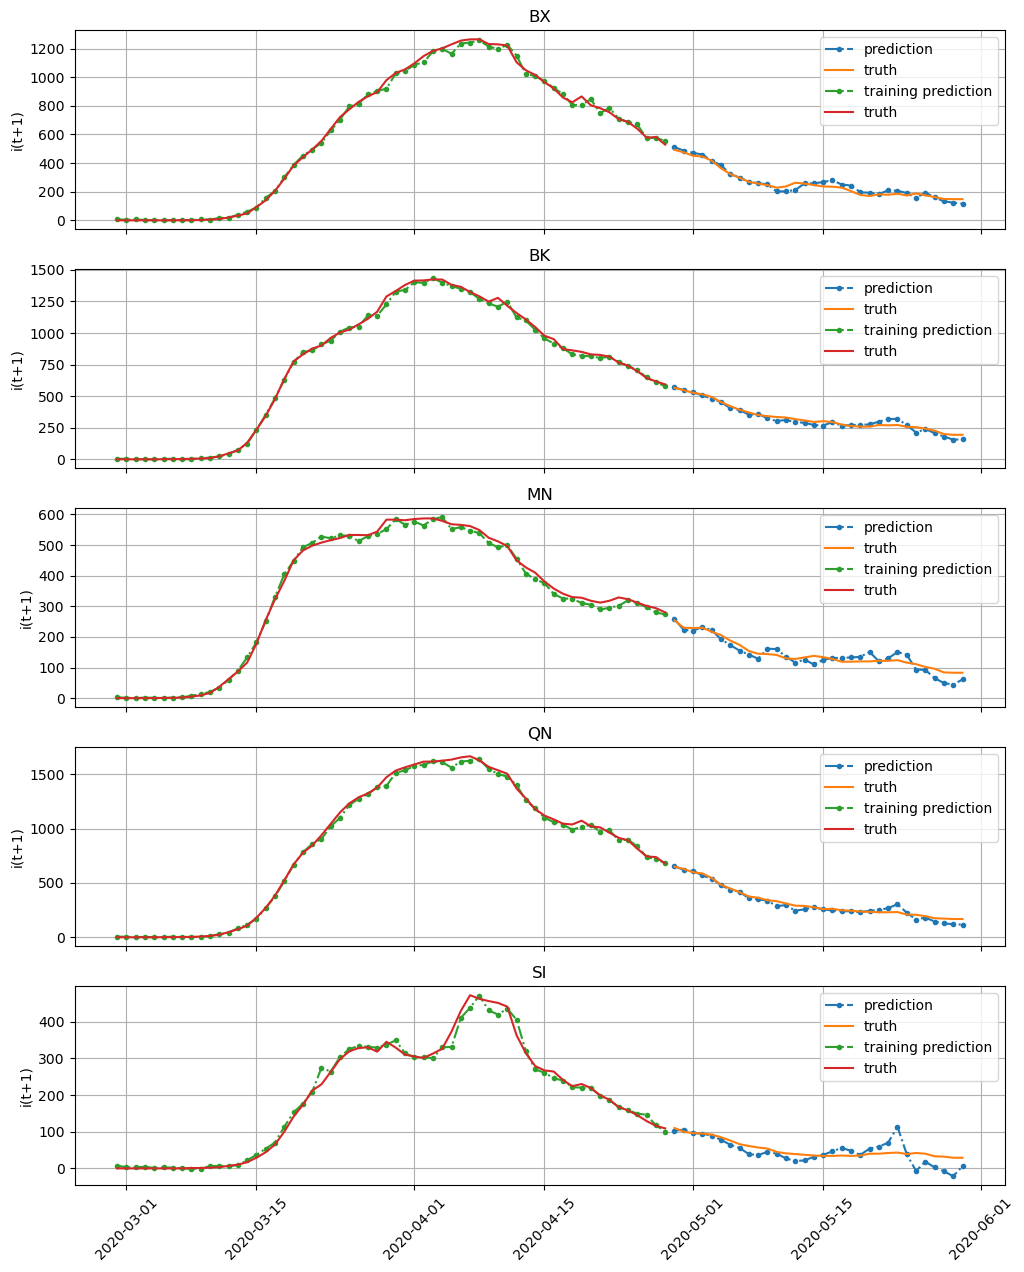

In [119]:
fig, ax = plt.subplots(5, figsize=(12,15), sharex=True)

for i, f in enumerate(fips_list):
    ax[i].plot(pred_df.loc[pred_df['fips'] == str(f), 'date'], pred_df.loc[pred_df['fips'] == str(f), 'pred'].values, '.-.', label='prediction')
    ax[i].plot(pred_df.loc[pred_df['fips'] == str(f), 'date'], pred_df.loc[pred_df['fips'] == str(f), 'truth'].values, '-', label='truth')

    ax[i].plot(train_df.loc[train_df['fips'] == str(f), 'date'], train_df.loc[train_df['fips'] == str(f), 'pred'].values, '.-.', label='training prediction')
    ax[i].plot(train_df.loc[train_df['fips'] == str(f), 'date'], train_df.loc[train_df['fips'] == str(f), 'truth'].values, '-', label='truth')
    
    ax[i].grid()
    ax[i].legend()
    ax[i].set_title(FIPS_BOROUGH_MAP[f])
    ax[i].set_ylabel(r'i(t+1)')

plt.xticks(rotation=45)


In [120]:
x_t

tensor([[  0.,   0.,   0.,  ...,   8.,   4.,  -1.],
        [  0.,   0.,   0.,  ...,   3.,   6.,  -1.],
        [  1.,   0.,   0.,  ...,  -1.,   6.,   0.],
        ...,
        [ 38.,  83.,  74.,  ..., -66., -30.,  11.],
        [110., 168., 212.,  ..., -56., -34.,  13.],
        [ 15.,  29.,  27.,  ..., -38., -21.,  10.]])